In [193]:
%matplotlib inline

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy.stats as stats

# Load the data and group it by unique keys for visualization

In [129]:
df_put = pd.read_table("loops_13.putative_cdr.txt", sep="\t")
df_cdr = pd.read_table("loops_13.real_cdr.txt", sep="\t")

In [130]:
df_put.head()

,pdb_id_kmer,chain_id_kmer,start_kmer,len_tcr,pos_tcr,aa_kmer,x_kmer,y_kmer,z_kmer,rmsd
0,12ca,A,72,13,0,A,0.000000,0.000000,0.000000,1.471901
1,12ca,A,72,13,1,V,2.435867,0.419666,2.914133,1.471901
2,12ca,A,72,13,2,L,3.901272,-1.472012,5.806936,1.471901
3,12ca,A,72,13,3,K,5.112862,0.373801,8.957265,1.471901
4,12ca,A,72,13,4,G,5.346375,-0.093429,12.738140,1.471901


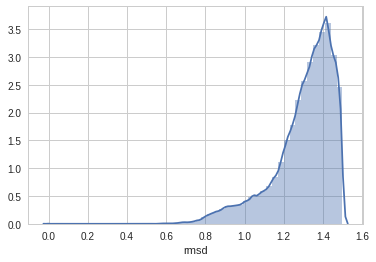

In [143]:
sns.distplot(df_put["rmsd"])

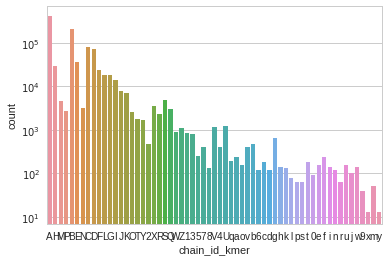

In [157]:
sns.countplot(df_put["chain_id_kmer"], log="y")

In [131]:
df_cdr.head()

,pdb_id,tcr_chain,len_tcr,pos_tcr,aa_tcr,x,y,z
0,2iam,TRA,13,0,C,0.000000,0.000000,0.000000
1,2iam,TRA,13,1,A,2.509573,1.112225,2.513987
2,2iam,TRA,13,2,A,3.364967,-0.345859,5.977036
3,2iam,TRA,13,3,L,5.778524,0.067249,8.943966
4,2iam,TRA,13,4,I,8.380416,-2.555646,9.870885


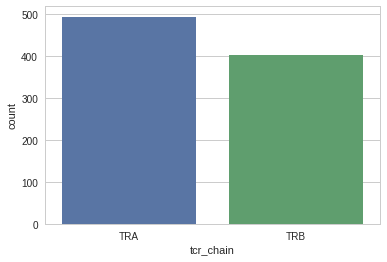

In [145]:
sns.countplot(df_cdr["tcr_chain"])

In [189]:
df = df_put.pivot_table("x_kmer", ["pdb_id_kmer", "chain_id_kmer", "start_kmer"], columns="pos_tcr")
df = df.reset_index()

df2 = df_put.pivot_table("aa_kmer", ["pdb_id_kmer", "chain_id_kmer", "start_kmer"], aggfunc=sum)
df2 = df2.reset_index()

df["sequence"] = df2["aa_kmer"]
df["key"] = df["pdb_id_kmer"] + "_" + df["chain_id_kmer"] + "_" + pd.Series(list(map(str, df["start_kmer"])))
df.drop(["pdb_id_kmer", "chain_id_kmer", "start_kmer"], axis=1, inplace=True)
df = df[["key", "sequence", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
df.head()

pos_tcr,key,sequence,0,1,2,3,4,5,6,7,8,9,10,11,12
0,12ca_A_72,AVLKGGPLDGTYR,0.0,2.435867,3.901272,5.112862,5.346375,6.424403,10.237835,10.422076,11.773136,10.111284,7.667701,7.872698,6.054439
1,12e8_H_47,IGWIDPEIGDTEY,0.0,2.608043,3.500156,5.651162,7.197959,6.547158,9.224579,12.119193,10.590880,11.240486,8.724633,7.982416,6.069228
2,12e8_M_193,CEATHKTSTSPIV,0.0,2.559624,3.279936,5.192563,6.338426,9.012737,11.169627,12.315048,12.539943,11.822830,8.221191,7.537343,6.005590
3,12e8_P_47,IGWIDPEIGDTEY,0.0,2.531457,3.458591,5.535513,7.100307,6.451582,8.845555,11.884481,10.683487,11.162031,8.671444,7.938718,6.066889
4,132l_A_48,GSTDYGILQINSR,0.0,3.120708,3.342358,5.694073,7.152789,8.495722,10.194527,11.626809,8.675602,10.739508,8.774272,8.025248,8.187382


In [133]:
df_put_x = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "x_kmer")
df_put_y = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "y_kmer")
df_put_z = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "z_kmer")

df_cdr_x = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "x")
df_cdr_y = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "y")
df_cdr_z = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "z")

(976690, 6)
(897, 5)


# Visualization

75130
69


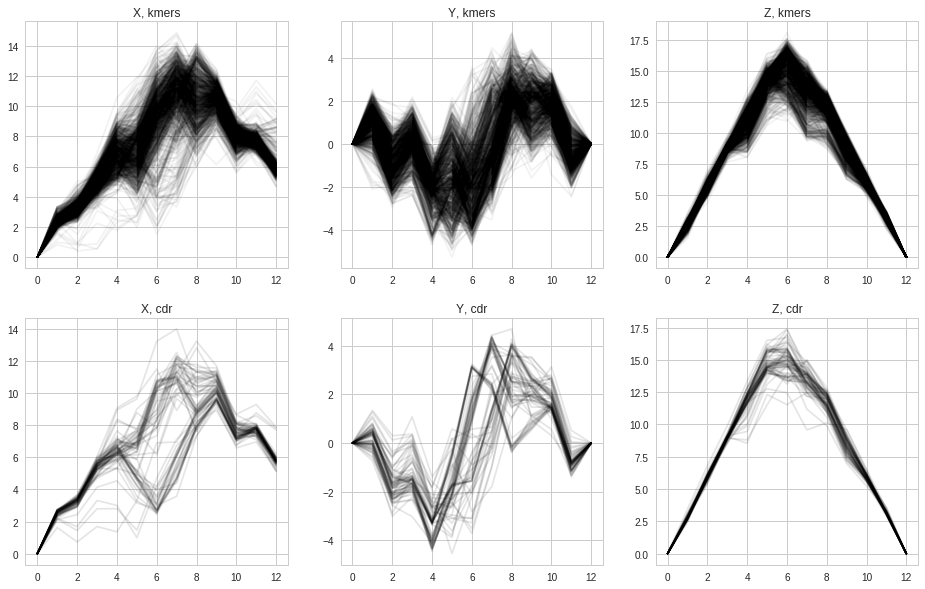

In [190]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
ax[0,0].set_title("X, kmers")
ax[0,1].set_title("Y, kmers")
ax[0,2].set_title("Z, kmers")
ax[1,0].set_title("X, cdr")
ax[1,1].set_title("Y, cdr")
ax[1,2].set_title("Z, cdr")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)

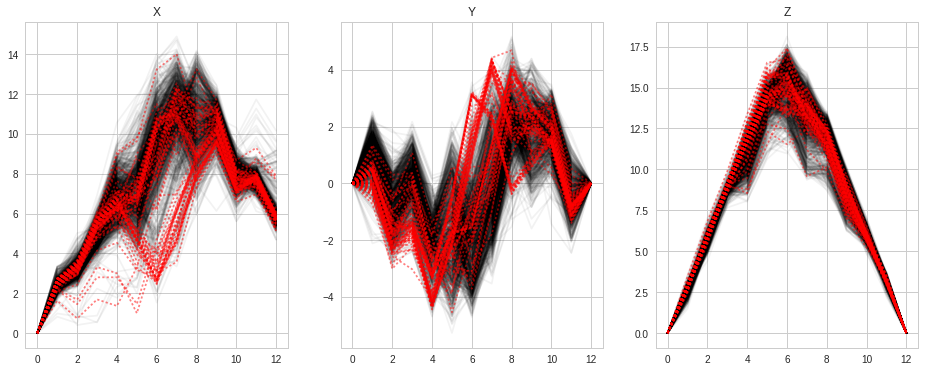

In [192]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)

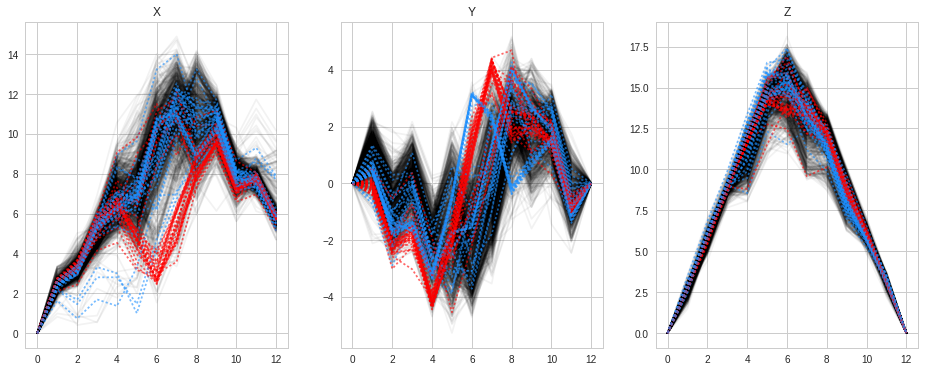

In [191]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)

# Anomaly analysis

In [164]:
df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 6) & (df_cdr_x["value"] < 6) & (df_cdr_x["tcr_chain"] == "TRA"), :]

,pdb_id,tcr_chain,pos_tcr,variable,value
864,3pqy,TRA,6,x,4.706501
890,4z7v,TRA,6,x,4.205619


In [167]:
df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 6) & (df_cdr_x["value"] > 6) & (df_cdr_x["tcr_chain"] == "TRB"), :]

,pdb_id,tcr_chain,pos_tcr,variable,value
32,2xn9,TRB,6,x,11.144908
71,3vxr,TRB,6,x,9.548838
97,3vxs,TRB,6,x,9.711765
136,4y1a,TRB,6,x,10.337111
279,4y19,TRB,6,x,8.448482
331,3o4l,TRB,6,x,11.509035
877,1d9k,TRB,6,x,10.139364


# Correlations among coordinates

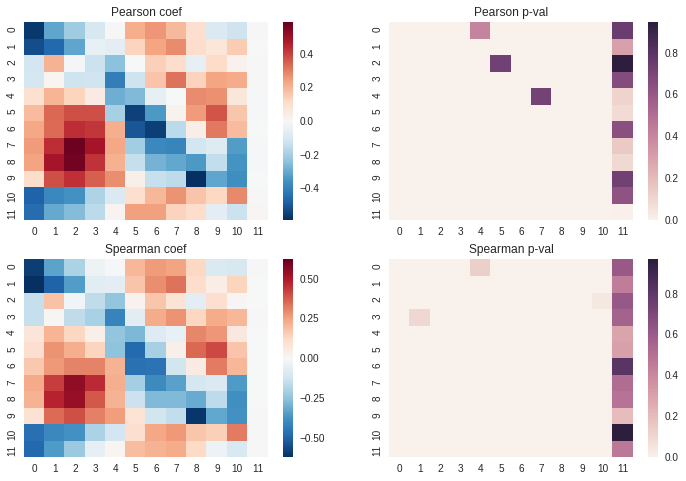

In [213]:
def plot_heatmap(df_x, df_y):
    fig, ax = plt.subplots(2,2, figsize=(12,8))

    cors = np.zeros((12,12))
    pvals = np.zeros((12,12))
    for i in range(1,13):
        for j in range(1,13):
            val = stats.pearsonr(df_x.loc[df_x.pos_tcr == i, "value"], df_y.loc[df_y.pos_tcr == j, "value"])
            cors[i-1,j-1] = val[0]
            pvals[i-1,j-1] = val[1]

    ax[0,0].set_title("Pearson coef")
    sns.heatmap(cors, ax=ax[0,0])
    ax[0,1].set_title("Pearson p-val")
    sns.heatmap(pvals, ax=ax[0,1])


    cors = np.zeros((12,12))
    pvals = np.zeros((12,12))
    for i in range(1,13):
        for j in range(1,13):
            val = stats.spearmanr(df_x.loc[df_x.pos_tcr == i, "value"], df_y.loc[df_y.pos_tcr == j, "value"])
            cors[i-1,j-1] = val[0]
            pvals[i-1,j-1] = val[1]

    ax[1,0].set_title("Spearman coef")
    sns.heatmap(cors, ax=ax[1,0])
    ax[1,1].set_title("Spearman p-val")
    sns.heatmap(pvals, ax=ax[1,1])

    
plot_heatmap(df_put_x, df_put_y)

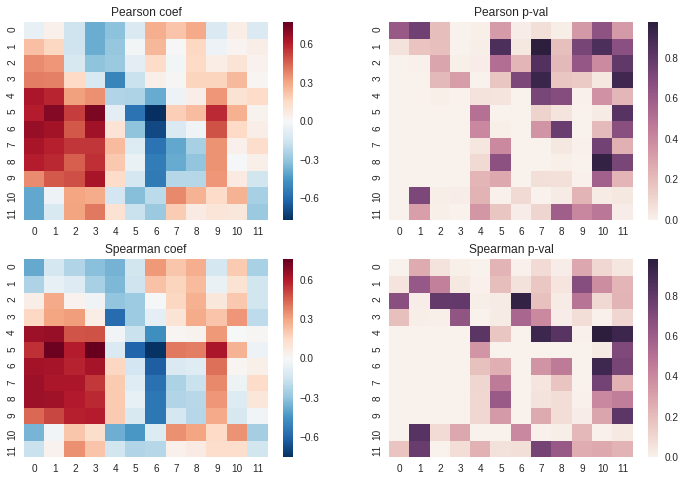

In [214]:
plot_heatmap(df_cdr_x, df_cdr_y)